In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torch_snippets import Report

In [195]:
# constants
dataset_path = 'datasets/brain_tumor_dataset/'
root_path = 'datasets/'

In [ ]:
# uncomment the following cells: to mount google drive if using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# uncomment the following cells: to install the required packages
# !pip install torch_snippets

In [ ]:
# uncomment the following cells: dataset path if using Google Colab
# dataset_path = '/content/drive/MyDrive/nada_dataset/datasets/brain_tumor_dataset/'
# root_path = '/content/drive/MyDrive/nada_dataset/datasets/'

## Data Preprocessing

In [55]:
# separate image dataset into train, test and validation splits
for CLASS in os.listdir(dataset_path):
    if CLASS == '.DS_Store':
        continue
    for IMAGE in os.listdir(dataset_path + CLASS):
        if IMAGE == '.DS_Store':
            continue
        if IMAGE.endswith('.jpeg') or IMAGE.endswith('.jpg'):
            IMAGE_PATH = dataset_path + CLASS + '/' + IMAGE
            if np.random.rand() < 0.8:
                shutil.copy(IMAGE_PATH, 'datasets/train/' + CLASS + '/' + IMAGE)
            elif np.random.rand() < 0.5:
                shutil.copy(IMAGE_PATH, 'datasets/val/' + CLASS + '/' + IMAGE)
            else:
                shutil.copy(IMAGE_PATH, 'datasets/test/' + CLASS + '/' + IMAGE)

## Data Loading

In [196]:
# create the transform for the training, validation and testing sets
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.2, 0.6),
    transforms.CenterCrop(224),
    transforms.RandomInvert(),
])
# define batch size
batch_size = 10

# create training, validation and testing sets
trainset = torchvision.datasets.ImageFolder(root=root_path + 'train/',
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

valset = torchvision.datasets.ImageFolder(root=root_path + 'val/',
                                          transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=root_path + 'test/',
                                           transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [284]:
# count the number of images per class in the training, validation and testing sets considering the batch size
classes = ('yes', 'no')
train_class_count = {'yes': 0, 'no': 0}
for data in trainloader:
    images, labels = data
    for label in labels:
        train_class_count[classes[label]] += 1

In [285]:
val_class_count = {'yes': 0, 'no': 0}
for data in valloader:
    images, labels = data
    for label in labels:
        val_class_count[classes[label]] += 1

In [286]:
test_class_count = {'yes': 0, 'no': 0}
for data in testloader:
    images, labels = data
    for label in labels:
        test_class_count[classes[label]] += 1

Text(0.5, 0, 'Class')

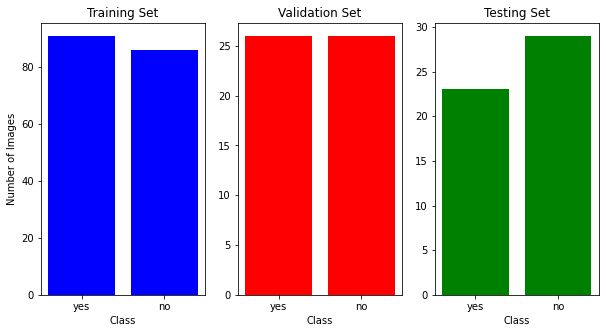

In [303]:
# horizontal bar plot of the number of images per class in the training, validation and testing sets
# create a 3x1 subplot
fig, axs = plt.subplots(1, 3, figsize=(10,5))
# plot the number of images per class in the training set
axs[0].bar(classes, train_class_count.values(), color='b')
axs[0].set_title('Training Set')
axs[0].set_ylabel('Number of Images')
axs[0].set_xlabel('Class')
# plot the number of images per class in the validation set
axs[1].bar(classes, val_class_count.values(), color='r')
axs[1].set_title('Validation Set')
axs[1].set_xlabel('Class')
# plot the number of images per class in the testing set
axs[2].bar(classes, test_class_count.values(), color='g')
axs[2].set_title('Testing Set')
axs[2].set_xlabel('Class')

In [ ]:
plt.bar(classes, [train_class_count['yes'], train_class_count['no']], color=['red', 'blue'])
plt.title('Number of images per class in the training set')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()




In [198]:
# printing size of loaders
print(f"Train set size: {len(trainloader) * batch_size}")
print(f"Validation set size: {len(valloader) * batch_size}")
print(f"Test set size: {len(testloader) * batch_size}")

Train set size: 180
Validation set size: 60
Test set size: 60


In [199]:
def image_show(img):
    """
    Function to show an image
    :param img: image to be shown
    """
    img = img / 2 + 0.5     # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # increment figure size
    plt.gcf().set_size_inches(12, 12)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


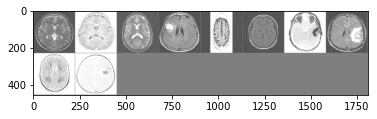

In [200]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show the images
image_show(torchvision.utils.make_grid(images))

## Model Architecture
In this section, we define the model architecture. As a first model, we create a simple CNN to perform the classification task.

In [202]:
# define the device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [207]:
# define a training function
def training_batch(batch, model, optimizer, criterion):
    """
    This function is used to train the model for one batch.
    :param batch: the batch of images and labels
    :param model: the model
    :param optimizer: the optimizer
    :param criterion: the loss function
    """
    # get the inputs
    inputs, labels = batch
    # model
    model.train()
    # move the inputs to the device
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # calculate accuracy
    acc = (outputs.max(1)[1] == labels).float().mean()
    loss.backward()
    optimizer.step()
    # return the loss and the accuracy
    return loss.item(), acc.item()

In [208]:
# define a validation function
@torch.no_grad()
def validation_batch(batch, model, criterion):
    """
    This function is used to validate the model.
    :param batch: a batch of images and labels
    :param model: the model to validate
    :param criterion: the loss function
    """
    # get the inputs
    inputs, labels = batch
    # model
    model.eval()
    # move the inputs to the device
    inputs, labels = inputs.to(device), labels.to(device)
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # calculate accuracy
    acc = (outputs.max(1)[1] == labels).float().mean()
    # return the loss and the accuracy
    return loss.item(), acc.item()

In [213]:
# define a testing function
def test_network(model, testloader, device):
    """
    Test the network on the test set.
    :param model: Model to test
    :param testloader: Test set
    :param device: device to use
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

### Simple CNN

In [201]:
# define a simple Convolutional Neural Network for the classification task of black and white images
class Net(nn.Module):
    """
    Simple CNN for the classification task of black and white images
    """
    def __init__(self,):
        super(Net,self).__init__()
        self.network_list=[nn.Conv2d(1,64,5),nn.ReLU(),nn.BatchNorm2d(64),nn.MaxPool2d(3,2)]
        self.network_list+=[nn.Conv2d(64,128,3),nn.ReLU(),nn.BatchNorm2d(128),nn.MaxPool2d(3,2)]
        self.network_list+=[nn.Conv2d(128,256,3),nn.ReLU(),nn.BatchNorm2d(256),nn.MaxPool2d(3,2)]
        self.network_list+=[nn.Conv2d(256,256,3),nn.ReLU(),nn.BatchNorm2d(256),nn.MaxPool2d(3,2)]
        self.network_list+=[nn.Conv2d(256,512,3),nn.ReLU(),nn.BatchNorm2d(512),nn.MaxPool2d(5,2)]
        self.network_list+=[nn.Conv2d(512,512,1),nn.ReLU(),nn.BatchNorm2d(512),nn.MaxPool2d(3,1)]
        self.cnn=nn.Sequential(*self.network_list)
        self.fn=nn.Sequential(nn.Linear(512,128),
                              nn.ReLU(),
                             nn.Linear(128,2))
    def forward(self,x):
        x=self.cnn(x)
        x=nn.Flatten()(x)
        return self.fn(x)

In [203]:
net = Net()

In [204]:
# move the network to the device
model = net.to(device)

In [ ]:
# if cuda cores are available, move the model to the GPU
if torch.cuda.is_available():
    model.cuda()

In [205]:
# summary of the network
from torchsummary import summary
summary(net, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 220, 220]           1,664
              ReLU-2         [-1, 64, 220, 220]               0
       BatchNorm2d-3         [-1, 64, 220, 220]             128
         MaxPool2d-4         [-1, 64, 109, 109]               0
            Conv2d-5        [-1, 128, 107, 107]          73,856
              ReLU-6        [-1, 128, 107, 107]               0
       BatchNorm2d-7        [-1, 128, 107, 107]             256
         MaxPool2d-8          [-1, 128, 53, 53]               0
            Conv2d-9          [-1, 256, 51, 51]         295,168
             ReLU-10          [-1, 256, 51, 51]               0
      BatchNorm2d-11          [-1, 256, 51, 51]             512
        MaxPool2d-12          [-1, 256, 25, 25]               0
           Conv2d-13          [-1, 256, 23, 23]         590,080
             ReLU-14          [-1, 256,

In [206]:
# define a loss function and a optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [210]:
number_of_epochs = 10
log = Report(number_of_epochs)
for epoch in range(number_of_epochs):
    N = len(trainloader)
    # train the network
    for i, batch in enumerate(trainloader):
        loss, acc = training_batch(batch, model, optimizer, criterion)
        log.record(epoch+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(valloader)
    # validate the network
    for i, batch in enumerate(valloader):
        loss, acc = validation_batch(batch, model, criterion)
        log.record(epoch+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch + 1)

EPOCH: 1.000	trn_loss: 0.683	trn_acc: 0.576	val_loss: 0.690	val_acc: 0.560	(74.17s - 667.51s remaining)
EPOCH: 2.000	trn_loss: 0.569	trn_acc: 0.682	val_loss: 0.666	val_acc: 0.600	(147.84s - 591.37s remaining)
EPOCH: 3.000	trn_loss: 0.524	trn_acc: 0.734	val_loss: 0.587	val_acc: 0.667	(222.36s - 518.85s remaining)
EPOCH: 4.000	trn_loss: 0.471	trn_acc: 0.759	val_loss: 0.473	val_acc: 0.750	(295.71s - 443.57s remaining)
EPOCH: 5.000	trn_loss: 0.390	trn_acc: 0.814	val_loss: 0.324	val_acc: 0.867	(370.21s - 370.21s remaining)
EPOCH: 6.000	trn_loss: 0.346	trn_acc: 0.853	val_loss: 0.384	val_acc: 0.783	(445.14s - 296.76s remaining)
EPOCH: 7.000	trn_loss: 0.380	trn_acc: 0.814	val_loss: 0.310	val_acc: 0.917	(521.58s - 223.53s remaining)
EPOCH: 8.000	trn_loss: 0.407	trn_acc: 0.829	val_loss: 0.301	val_acc: 0.850	(598.10s - 149.53s remaining)
EPOCH: 9.000	trn_loss: 0.340	trn_acc: 0.850	val_loss: 0.293	val_acc: 0.933	(673.53s - 74.84s remaining)
EPOCH: 10.000	trn_loss: 0.328	trn_acc: 0.861	val_loss: 0.

100%|██████████| 111/111 [00:00<00:00, 14188.95it/s]


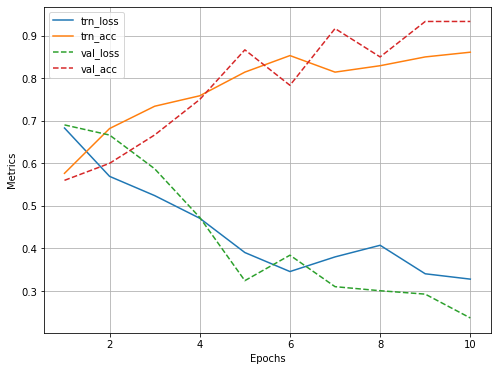

In [211]:
# plot the loss and accuracy
log.plot_epochs(title="Simple CNN")

In [ ]:
# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Simple CNN", fontsize=20)
log.plot(['val_acc','trn_acc'], title="Accuracy" , ax=ax[0])
log.plot(['val_loss','trn_loss'], title="Loss", ax=ax[1])

In [214]:
# calculate the accuracy on the test set
test_network(model, testloader, device)

Accuracy of the network on the test images: 94 %


### Pretrained CNN models


In [215]:
def set_parameter_requires_grad(model, feature_extracting):
    """
    Function that sets the parameters of the model that will be fine-tuned
    :param model: pytorch model
    :param feature_extracting: boolean flag for feature extracting. When False, we fine-tune the whole model,
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [216]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    """
    Initialize the computer vision model, can be  pretrained or not.
    :param model_name: name of the pytorch model
    :param num_classes: number of classes
    :param feature_extract:
    :param use_pretrained: When True, a pretrained model will be loaded
    :return: model, image input size
    """
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        # modify the model to accept black and white images
        model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        # modify the model to accept black and white images
        model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 128

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        # modify the model to accept black and white images
        model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        # modify the model to accept black and white images
        model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        # modify the model to accept black and white images
        model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

#### ResNet18

In [217]:
# Define the model and the number of classes
model_name = "resnet18"
num_classes = 2

In [222]:
model, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

In [ ]:
# if cuda cores are available, move the model to the GPU
if torch.cuda.is_available():
    model.cuda()

In [223]:
optimizer =  optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [224]:
number_of_epochs = 10
log = Report(number_of_epochs)
for epoch in range(number_of_epochs):
    N = len(trainloader)
    # train the network
    for i, batch in enumerate(trainloader):
        loss, acc = training_batch(batch, model, optimizer, criterion)
        log.record(epoch+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(valloader)
    # validate the network
    for i, batch in enumerate(valloader):
        loss, acc = validation_batch(batch, model, criterion)
        log.record(epoch+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch + 1)

EPOCH: 1.000	trn_loss: 0.933	trn_acc: 0.500	val_loss: 3.925	val_acc: 0.580	(60.77s - 1154.67s remaining)
EPOCH: 2.000	trn_loss: 0.730	trn_acc: 0.534	val_loss: 2.122	val_acc: 0.600	(121.37s - 1092.32s remaining)
EPOCH: 3.000	trn_loss: 0.706	trn_acc: 0.604	val_loss: 0.578	val_acc: 0.617	(181.04s - 1025.87s remaining)
EPOCH: 4.000	trn_loss: 0.646	trn_acc: 0.590	val_loss: 0.567	val_acc: 0.667	(241.69s - 966.75s remaining)
EPOCH: 5.000	trn_loss: 0.663	trn_acc: 0.640	val_loss: 0.497	val_acc: 0.800	(302.76s - 908.28s remaining)
EPOCH: 6.000	trn_loss: 0.518	trn_acc: 0.756	val_loss: 0.479	val_acc: 0.750	(363.00s - 847.00s remaining)
EPOCH: 7.000	trn_loss: 0.535	trn_acc: 0.723	val_loss: 0.583	val_acc: 0.733	(423.70s - 786.86s remaining)
EPOCH: 8.000	trn_loss: 0.532	trn_acc: 0.732	val_loss: 0.435	val_acc: 0.850	(484.33s - 726.49s remaining)
EPOCH: 9.000	trn_loss: 0.454	trn_acc: 0.790	val_loss: 0.613	val_acc: 0.667	(546.66s - 668.14s remaining)
EPOCH: 10.000	trn_loss: 0.489	trn_acc: 0.785	val_loss

100%|██████████| 121/121 [00:00<00:00, 4450.17it/s]


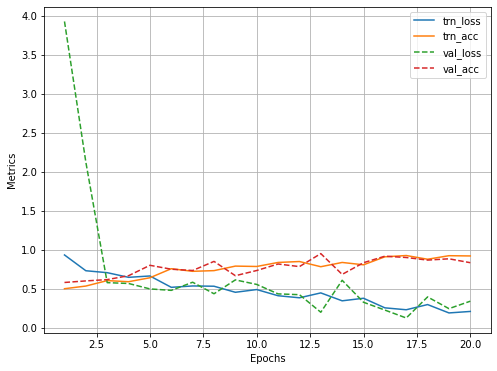

In [225]:
# plot the loss and accuracy
log.plot_epochs(title="ResNet18")

In [ ]:
# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("ResNet18", fontsize=20)
log.plot(['val_acc','trn_acc'], title="Accuracy" , ax=ax[0])
log.plot(['val_loss','trn_loss'], title="Loss", ax=ax[1])

In [227]:
# calculate the accuracy on the test set
test_network(model=model, testloader=testloader, device=device)

Accuracy of the network on the test images: 94 %


#### ResNet34

In [229]:
# Define the model and the number of classes
model_name = "resnet34"
num_classes = 2

In [230]:
model, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

In [ ]:
# if cuda cores are available, move the model to the GPU
if torch.cuda.is_available():
    model.cuda()

In [231]:
optimizer =  optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [232]:
number_of_epochs = 10
log = Report(number_of_epochs)
for epoch in range(number_of_epochs):
    N = len(trainloader)
    # train the network
    for i, batch in enumerate(trainloader):
        loss, acc = training_batch(batch, model, optimizer, criterion)
        log.record(epoch+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(valloader)
    # validate the network
    for i, batch in enumerate(valloader):
        loss, acc = validation_batch(batch, model, criterion)
        log.record(epoch+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch + 1)

EPOCH: 1.000	trn_loss: 1.234	trn_acc: 0.512	val_loss: 32.405	val_acc: 0.520	(124.84s - 1123.59s remaining)
EPOCH: 2.000	trn_loss: 0.713	trn_acc: 0.634	val_loss: 1.076	val_acc: 0.567	(249.26s - 997.05s remaining)
EPOCH: 3.000	trn_loss: 0.670	trn_acc: 0.662	val_loss: 1.023	val_acc: 0.617	(377.21s - 880.15s remaining)
EPOCH: 4.000	trn_loss: 0.787	trn_acc: 0.643	val_loss: 0.548	val_acc: 0.717	(501.66s - 752.49s remaining)
EPOCH: 5.000	trn_loss: 0.683	trn_acc: 0.599	val_loss: 0.670	val_acc: 0.733	(628.59s - 628.59s remaining)
EPOCH: 6.000	trn_loss: 0.611	trn_acc: 0.640	val_loss: 0.569	val_acc: 0.683	(749.74s - 499.83s remaining)
EPOCH: 7.000	trn_loss: 0.635	trn_acc: 0.627	val_loss: 0.449	val_acc: 0.783	(873.42s - 374.32s remaining)
EPOCH: 8.000	trn_loss: 0.550	trn_acc: 0.734	val_loss: 0.497	val_acc: 0.817	(998.92s - 249.73s remaining)
EPOCH: 9.000	trn_loss: 0.558	trn_acc: 0.702	val_loss: 1.021	val_acc: 0.550	(1122.90s - 124.77s remaining)
EPOCH: 10.000	trn_loss: 0.644	trn_acc: 0.632	val_los

100%|██████████| 111/111 [00:00<00:00, 12199.13it/s]


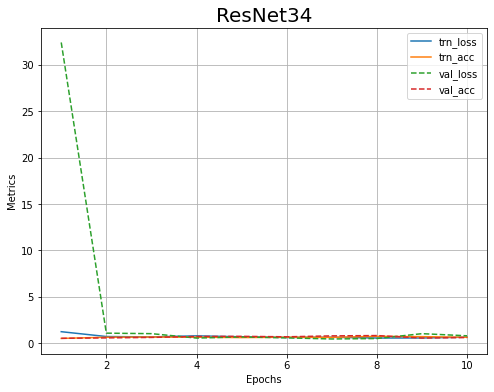

In [279]:
# plot the loss and accuracy
log.plot_epochs(title="ResNet34")

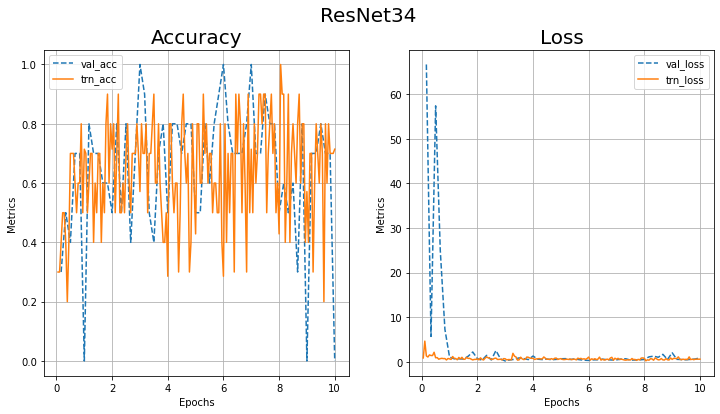

In [278]:
# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("ResNet34", fontsize=20)
log.plot(['val_acc','trn_acc'], title="Accuracy" , ax=ax[0])
log.plot(['val_loss','trn_loss'], title="Loss", ax=ax[1])

In [265]:
# calculate the accuracy on the test set
test_network(model=model, testloader=testloader, device=device)

Accuracy of the network on the test images: 75 %


In [267]:
log.logged

['trn_loss', 'trn_acc', 'val_loss', 'val_acc']

#### AlexNet

In [160]:
# Define the model and the number of classes
model_name = "alexnet"
num_classes = 2

In [161]:
model, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

In [ ]:
# if cuda cores are available, move the model to the GPU
if torch.cuda.is_available():
    model.cuda()

In [ ]:
optimizer =  optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [162]:
number_of_epochs = 10
log = Report(number_of_epochs)
for epoch in range(number_of_epochs):
    N = len(trainloader)
    # train the network
    for i, batch in enumerate(trainloader):
        loss, acc = training_batch(batch, model, optimizer, criterion)
        log.record(epoch+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(valloader)
    # validate the network
    for i, batch in enumerate(valloader):
        loss, acc = validation_batch(batch, model, criterion)
        log.record(epoch+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch + 1)

EPOCH: 1.000	trn_loss: 0.694	trn_acc: 0.472	val_loss: 0.694	val_acc: 0.479	(9.51s - 85.61s remaining)
EPOCH: 2.000	trn_loss: 0.693	trn_acc: 0.483	val_loss: 0.693	val_acc: 0.500	(18.77s - 75.09s remaining)
EPOCH: 3.000	trn_loss: 0.693	trn_acc: 0.478	val_loss: 0.693	val_acc: 0.519	(27.98s - 65.30s remaining)
EPOCH: 4.000	trn_loss: 0.693	trn_acc: 0.472	val_loss: 0.693	val_acc: 0.519	(37.23s - 55.84s remaining)
EPOCH: 5.000	trn_loss: 0.693	trn_acc: 0.472	val_loss: 0.694	val_acc: 0.462	(46.47s - 46.47s remaining)
EPOCH: 6.000	trn_loss: 0.694	trn_acc: 0.461	val_loss: 0.693	val_acc: 0.519	(55.75s - 37.17s remaining)
EPOCH: 7.000	trn_loss: 0.693	trn_acc: 0.506	val_loss: 0.693	val_acc: 0.481	(65.01s - 27.86s remaining)
EPOCH: 8.000	trn_loss: 0.694	trn_acc: 0.472	val_loss: 0.693	val_acc: 0.500	(74.26s - 18.57s remaining)
EPOCH: 9.000	trn_loss: 0.694	trn_acc: 0.467	val_loss: 0.693	val_acc: 0.519	(83.60s - 9.29s remaining)
EPOCH: 10.000	trn_loss: 0.693	trn_acc: 0.494	val_loss: 0.693	val_acc: 0.481

100%|██████████| 111/111 [00:00<00:00, 5514.96it/s]


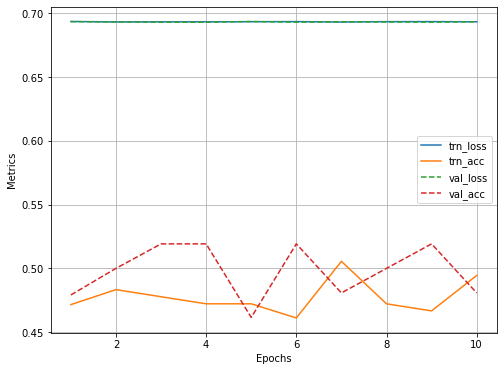

In [164]:
# plot the loss and accuracy
log.plot_epochs(title="AlexNet")

In [ ]:
# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("AlexNet", fontsize=20)
log.plot(['val_acc','trn_acc'], title="Accuracy" , ax=ax[0])
log.plot(['val_loss','trn_loss'], title="Loss", ax=ax[1])

In [ ]:
# calculate the accuracy on the test set
test_network(model=model, testloader=testloader, device=device)

#### VGG11

In [190]:
# Define the model and the number of classes
model_name = "vgg"
num_classes = 2

In [191]:
model, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

In [ ]:
# if cuda cores are available, move the model to the GPU
if torch.cuda.is_available():
    model.cuda()

In [ ]:
optimizer =  optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [192]:
number_of_epochs = 10
log = Report(number_of_epochs)
for epoch in range(number_of_epochs):
    N = len(trainloader)
    # train the network
    for i, batch in enumerate(trainloader):
        loss, acc = training_batch(batch, model, optimizer, criterion)
        log.record(epoch+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(valloader)
    # validate the network
    for i, batch in enumerate(valloader):
        loss, acc = validation_batch(batch, model, criterion)
        log.record(epoch+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch + 1)

EPOCH: 1.000	trn_loss: 0.743	trn_acc: 0.541	val_loss: 0.699	val_acc: 0.460	(94.84s - 853.59s remaining)
EPOCH: 2.000	trn_loss: 0.766	trn_acc: 0.498	val_loss: 0.710	val_acc: 0.483	(188.50s - 754.01s remaining)
EPOCH: 3.000	trn_loss: 0.765	trn_acc: 0.513	val_loss: 0.681	val_acc: 0.533	(283.59s - 661.71s remaining)
EPOCH: 4.000	trn_loss: 0.764	trn_acc: 0.465	val_loss: 0.696	val_acc: 0.467	(377.82s - 566.73s remaining)
EPOCH: 5.000	trn_loss: 0.782	trn_acc: 0.493	val_loss: 0.714	val_acc: 0.417	(472.05s - 472.05s remaining)
EPOCH: 6.000	trn_loss: 0.743	trn_acc: 0.548	val_loss: 0.692	val_acc: 0.450	(567.65s - 378.43s remaining)
EPOCH: 7.000	trn_loss: 0.802	trn_acc: 0.429	val_loss: 0.708	val_acc: 0.500	(661.91s - 283.67s remaining)
EPOCH: 8.000	trn_loss: 0.792	trn_acc: 0.491	val_loss: 0.697	val_acc: 0.467	(756.44s - 189.11s remaining)
EPOCH: 9.000	trn_loss: 0.803	trn_acc: 0.479	val_loss: 0.673	val_acc: 0.550	(850.79s - 94.53s remaining)
EPOCH: 10.000	trn_loss: 0.781	trn_acc: 0.475	val_loss: 0.

100%|██████████| 111/111 [00:00<00:00, 14419.22it/s]


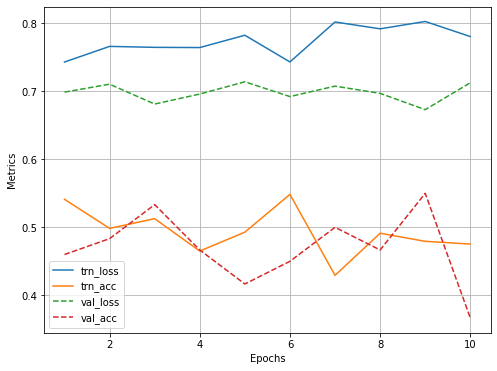

In [193]:
# plot the loss and accuracy
log.plot_epochs(title="VGG11")

In [ ]:
# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("VGG11", fontsize=20)
log.plot(['val_acc','trn_acc'], title="Accuracy" , ax=ax[0])
log.plot(['val_loss','trn_loss'], title="Loss", ax=ax[1])

In [ ]:
# calculate the accuracy on the test set
test_network(model=model, testloader=testloader, device=device)